# Interactive hypothesis testing

If you need to test a hypothesis interactively along multiple dimensions or their combinations, we are showing below an example demonstrating how this can be achieved with [atoti](https://docs.atoti.io).

atoti provides a python interface to define custom aggregation function - we will look at an example of implementing a paired t-test as an aggregation function. Plus, it provides an interface to create dashboards and share results with customers.

<img src="./app-preview.gif" alt="Interactive app preview" width="70%" style="display:block;margin-left: auto;margin-right: auto;">

# Imports

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.stats import norm, t

In [2]:
import atoti as tt

Welcome to atoti 0.4.3.20200729154535!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Raw data

In [32]:
# Example data is taken from kaggle user submission:
# https://www.kaggle.com/steveahn/memory-test-on-drugged-islanders-data
df = pd.read_csv("http://data.atoti.io/notebooks/drug-efficacy/Islander_data.csv")
df = df.reset_index()
df['Drug'] = "Drug " + df['Drug'].astype(str)
df['Happy_Sad_group'] = df['Happy_Sad_group'].map(lambda x: "Happy" if x=="H" else "Sad")
df.sample(5)

,index,first_name,last_name,age,Happy_Sad_group,Dosage,Drug,Mem_Score_Before,Mem_Score_After,Diff
154,154,Sophie,Takahashi,46,Sad,1,Drug T,82.4,83.1,0.7
87,87,Rin,Takahashi,30,Happy,1,Drug S,59.6,56.8,-2.8
59,59,Ren,Lopez,47,Happy,3,Drug A,65.6,86.4,20.8
12,12,Ayano,Kennedy,39,Happy,1,Drug A,35.5,40.7,5.2
39,39,Jun,Rodriguez,35,Sad,2,Drug A,40.8,63.0,22.2


In [4]:
# Vectorizing the measurements -  as we want a hierarchy to expand stats by "before" and "after"
df["MemoryScoresVector"] = (
    df["Mem_Score_Before"].astype(str) + ";" + df["Mem_Score_After"].astype(str)
)

## Launching atoti app

In [5]:
from atoti.config import create_config

config = create_config(metadata_db="./metadata.db")

session = tt.create_session(config=config)
observations_datastore = session.read_pandas(
    df, keys=["index"], array_sep=";", store_name="Observations"
)
cube = session.create_cube(observations_datastore)

h = cube.hierarchies
l = cube.levels
m = cube.measures

## URL of atoti app

The following cell displays URL of the atoti app:

In [6]:
session.url

'http://localhost:60829'

# Inline data visualization

By running the next cell, we embed a data visualization widget - to slice and dice data inside the notebook.

In [8]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Adding a custom grouping - age groups

I want to group obvervations by age. To achieve that, I'm creating and uploading **age to group mapping** into a separate data store:

In [9]:
age_groups_store = session.read_pandas(
    pd.DataFrame(
        data=[("0-25Y", i) for i in range(25)]
        + [("25Y - 40Y", i) for i in range(25, 40)]
        + [("40Y - 55Y", i) for i in range(40, 55)]
        + [("55Y+", i) for i in range(55, 100)],
        columns=["age group", "age"],
    ),
    keys=["age"],
    store_name="Age Groups",
)

observations_datastore.join(age_groups_store)

We will start using this grouping in one of the following cells.

# "Before and After" dimension

I have loaded the before and after measurements in vectorized format: (before, after), and now I want to access the first and the second elements using a "Before and After" hierarchy. 

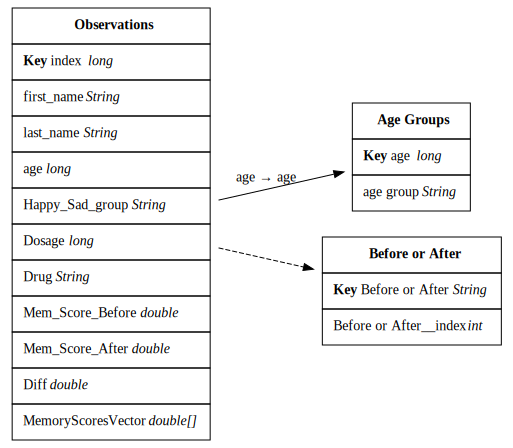

In [10]:
cube.create_parameter_hierarchy(
    "Before or After", ["Before", "After"], index_measure="Before After Index"
)

# Setting the Before and After to slicing to switch off
# the aggregation between before and after measurements
h["Before or After"].slicing = True

# Sorting the hierarchy, so that the Before measurements show first:
l["Before or After"].comparator = tt.comparator.DESC

# The new parameter hierarchy is visible in the cube schema:
display(cube.schema)

# Now having created a hierarchy for the "Before" and "After", let's link it to the "MemoryScores" vector
m["MemoryScores"] = m["MemoryScoresVector.MEAN"][m["Before After Index"]]

From the following visualization we can tell, that on average:
-    for the Drug **"T"** memory scores **did not increase** in all age groups,
-    for the Drug **"A"** memory scores **increased in both age groups**, with a bigger impact in group 25Y-50Y,
-    for the Drug **"S"** the scores **fluctuated**, they slighly decreased and slighly increased in groups 25Y-50Y and 50Y+ accordingly.

In [12]:
cube.visualize("Average memory score by drug")

Install and enable the atoti JupyterLab extension to see this widget.

# Slice-and-dice basic statistics

In [13]:
m["Mean"] = tt.agg.mean(m["MemoryScores"], scope=tt.scope.origin(l["index"]))
m["Mean"] = tt.agg.mean(m["MemoryScores"], scope=tt.scope.origin(l["index"]))
m["Std"] = tt.agg.std(m["MemoryScores"], scope=tt.scope.origin(l["index"]))
m["Min"] = tt.agg.min(m["MemoryScores"], scope=tt.scope.origin(l["index"]))
m["Max"] = tt.agg.max(m["MemoryScores"], scope=tt.scope.origin(l["index"]))
m["25%"] = tt.agg.quantile(m["MemoryScores"], 0.25, scope=tt.scope.origin(l["index"]))
m["50%"] = tt.agg.quantile(m["MemoryScores"], 0.50, scope=tt.scope.origin(l["index"]))
m["75%"] = tt.agg.quantile(m["MemoryScores"], 0.75, scope=tt.scope.origin(l["index"]))

We can now slice-and-dice those statistics using any attribute available in the data.

This is an example, where the Happy or Sad field has been put onto the columns. Every time I bring an additional attribute into the view, the statistics - such averages, standard deviation and quantiles - are recomputed from the raw data.

In [17]:
cube.visualize("Basic statistics slice-and-dice")

Install and enable the atoti JupyterLab extension to see this widget.

# Interactive Z confidence interval

In [18]:
alpha = 0.05

m["95% point"] = norm.ppf(1 - alpha / 2.0)
m["Z confidence left"] = m["Mean"] - m["95% point"] * m["Std"]
m["Z confidence right"] = m["Mean"] + m["95% point"] * m["Std"]

We have just created the metrics to visualize confidence intervals interactively.

In [20]:
cube.visualize("Interactive confidence intervals")

Install and enable the atoti JupyterLab extension to see this widget.

# Refining the application

In [21]:
# This cell is hiding undesired metrics created by default.
# To create a cube without any default metrics, create_cube need to be used with parameter mode = `no_measures`
m["MemoryScoresVector.SUM"].visible = False
m["MemoryScoresVector.MEAN"].visible = False
m["Mem_Score_Before.SUM"].visible = False
m["Mem_Score_After.SUM"].visible = False
m["Diff.SUM"].visible = False
m["Diff.MEAN"].formatter = "DOUBLE[0.00]"

# Paired t-test

Let's see how a paired t-test can be applied in atoti.

A [paired t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Paired_samples) is a classical routine that can help testing a medication efficacy, given the before and after measurements. We will check that the data provides evidence that will allow us to reject the null hypothesis:

- H0: on average, there's no difference in observations before and after, $\mu_{diff}=0$
- H1: on average, the score after is bigger than before, $\mu_{diff}>0$

To compute the t-statistic, we'd need mean, stdev and the number of observations:

$$t_{statistic} = \frac{\bar{x}}{s/\sqrt{n}}$$

The measure for the mean $\bar{x}$ - `Diff.MEAN` - and a measure for the number of observations $n$ - `contributors.COUNT` - were created automatically upon cube creation. Let's add a measure to compute stdev $s$.

In [22]:
# Measure displaying individual differences:
m["Diff"] = tt.agg.single_value(observations_datastore["Diff"])

# Computing standard deviation of differences:
m["Diff.Std"] = tt.agg.std(m["Diff"], scope=tt.scope.origin(l["index"]))

# Computing the t-statistic per formula above:
m["t-statistic"] = m["Diff.MEAN"] / (m["Diff.Std"] / tt.sqrt(m["contributors.COUNT"]))
m["t-statistic"].formatter = "DOUBLE[0.00]"

We will be comparing the `t-statistic` to the right tail _critical value_, and if it's above the critical value, we will conclude that the data provides the evidence to reject the null hypothesis. Let's load 95% critical value into the cube.

Now, depending on the number of observations for each cell, we will pick a critical value and visualize it as a measure:

In [23]:
# Loading a "table" of critical values, 101 values in total.
m["t-critical values list"] = [t.ppf(0.95, d) for d in range(1, 101)] + [1.645]

# Computing degrees of freedom as the number of observations minus 1:
df = m["contributors.COUNT"] - 1

# Shifting the df by -1 to use as an index and pick up critical value from the list:
df_as_index = df - 1

# If there're too many observations (more than 101), we'll cap it:
capped_df_as_index = tt.where(df_as_index > 100, 100, df_as_index)

# This measure will be looking up a critical value for the current scope:
m["t-critical"] = m["t-critical values list"][capped_df_as_index]

This measure is displaying wether the observed t-statistics is to the right from the critical value, i.e. there's evidence that H0 can be rejected. It will visualize the result of t-test every time we expand and collapse data.

In [24]:
m["Test Result"] = tt.where(
    m["t-statistic"] > m["t-critical"], "H0 rejected", "Can't reject H0"
)

In the next session we'll see how to use the measure created above to visualize the test result.

# Interactive hypothesis testing

Now we can experiment and re-group our data and apply the test interactively.

We expand by the name of the drug, then by dosages, then by patient "Happy/Sad" group, and this is what we found out:

- there's an evidence that **Drug A** was efficient overall, while drugs "S", "T" did not provide a significant improvement in the memory scores, 
- when we break down the Drug A observations **by dosage** -  we notice that only the dosages 1 and 2 are statistically efficient, 
- if we further expand to "Happy/Sad" group, and for the "Happy" patients only the higher dosage impacted the memory score.

In [26]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Quick simulation

Let's make a quick comparison of the test results under the 95%, 97.5%, 99% confidence levels by loading new critical values into simulations. As a reminder, we've been using the 95% critical values so far.

In [27]:
# creating a new simulation to override critical values, and giving a name to the initial values
confidence_levels = cube.setup_simulation(
    "Confidence Levels", replace=[m["t-critical values list"]], base_scenario="95%"
).scenarios
# creating new critical values based on 0.975 and 0.99 confidence levels
confidence_levels["97.5%"] = [t.ppf(0.975, d) for d in range(1, 101)] + [1.960]
confidence_levels["99%"] = [t.ppf(0.99, d) for d in range(1, 101)] + [2.326]

The below calculations show that for Drug S and Dosage 1, the hypothesis would be accepted at 95% and 97.5% level. But the increase in the memory score is quite small. Testing at 99% confidence level doesn't allow to reject the null hypothesis, that there's no much difference in the memory scores before and after treatment with Drug S and Dosage 1.

In [29]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Conclusion

In this notebook we have configured an analytical application for **exploratory data analysis**, that allows to **interactively browse** the data and re-compute statistics, such as mean, stdev, etc, as well as more complex functions - such as hypothesis test metrics - **on-the-fly**. Eventhough the example has a handfull of observation, atoti's backend is designed to handle big data. Please refer to this white page is you want to learn about the [technology](https://activeviam.com/images/pdf/white-papers/ActiveViam_Technical_White_Paper_-_ActivePivot.pdf) on atoti's backend.

The application comes with a **user interface**, so the results of the analysis can be visualized in a dashboard and presented to users:


In [30]:
session.url + "/#/dashboard/3f7"

'http://localhost:60829/#/dashboard/3f7'